# CHSH inequality

## Background

In this tutorial, you will run an experiment on a quantum computer to demonstrate the violation of the CHSH inequality with the Estimator primitive. 

The CHSH inequality, named after the authors Clauser, Horne, Shimony, and Holt, is used to experimentally prove Bell's theorem (1969). This theorem asserts that local hidden variable theories cannot account for some consequences of entanglement in quantum mechanics. The violation of the CHSH inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. This is an important experiment for understanding the foundation of quantum mechanics. 

The 2022 Nobel Prize for Physics was awarded to Alain Aspect, John Clauser and Anton Zeilinger in part for their pioneering work in quantum information science, and in particular, for their experiments with entangled photons demonstrating violation of Bell’s inequalities.

For this experiment, we will create an entangled pair on which we measure each qubit on two different bases. We will label the bases for the first qubit $A$ and $a$ and the bases for the second qubit $B$ and $b$.  This allows us to compute the CHSH quantity $S_1$:

$$
S_1 = A(B-b) + a(B+b).
$$

Each observable is either $+1$ or $-1$. Clearly, one of the terms $B\pm b$ must be $0$, and the other must be $\pm 2$.  Therefore, $S_1 = \pm 2$. The average value of $S_1$ must satisfy the inequality:

$$
|\langle S_1 \rangle|\leq 2.
$$

Expanding $S_1$ in terms of $A$, $a$, $B$, and $b$ results in:

$$
|\langle S_1 \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2
$$

You can define another CHSH quantity $S_2$:

$$
S_2 = A(B+b) - a(B-b),
$$

This leads to another inequality:

$$
|\langle S_2 \rangle| = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle| \leq 2
$$

If quantum mechanics can be described by local hidden variable theories, the previous inequalities must hold true. However, as you are going to demonstrate in this notebook, these inequalities can be violated in a quantum computer.  Therefore, quantum mechanics is not compatible with local hidden variable theories.

If you want to learn more theory, explore [Entanglement in Action](https://learning.quantum-computing.ibm.com/course/basics-of-quantum-information/entanglement-in-action#the-chsh-game) with John Watrous.

<iframe loading="lazy" width="800" height="450" style="margin-top: 40px; margin-bottom: 40px;" src="https://www.youtube.com/embed/GSsElSQgMbU?si=ZhRKJKHMLRq0g3E1&amp;start=2426" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

You will create an entangled pair between two qubits in a quantum computer by creating the Bell state $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$. Using the Estimator primitive, you can directly obtain the expectation values needed ($\langle AB \rangle, \langle Ab \rangle, \langle aB \rangle$, and $\langle ab \rangle$) to calculate the expectation values of the two CHSH quantities $\langle S_1\rangle$ and $\langle S_2\rangle$. Before the introduction of the Estimator primitive, you would have to construct the expectation values from the measurement outcomes.

You will measure the second qubit in the $Z$ and $X$ bases.  The first qubit will be measured also in orthogonal bases, but with an angle with respect to the second qubit, which we are going to sweep between $0$ and $2\pi$. As you will see, the Estimator primitive makes running parameterized circuits very easy. Rather than creating a series of CHSH circuits, you only need to create *one* CHSH circuit with a parameter specifying the measurement angle and a series of phase values for the parameter.

Finally, you will analyze the results and plot them against the measurement angle. You will see that for certain range of measurement angles, the expectation values of CHSH quantities $|\langle S_1\rangle| > 2$ or $|\langle S_2\rangle| > 2$, which demonstrates the violation of the CHSH inequality.

## Setup

In [35]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Batch

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [24]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibmq_manila'

## Map the problem to a quantum-native format

### Create a parameterized CHSH circuit 

First, we write the circuit with the parameter $\theta$, which we call `theta`. The [`Estimator` primitive](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Estimator#estimator) can enormously simplify circuit building and output analysis by directly providing expectation values of observables. Many problems of interest, especially for near-term applications on noisy systems, can be formulated in terms of expectation values. For maximum generalization, the [`Estimator` primitive](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Estimator#estimator) requires circuits with no measurements.

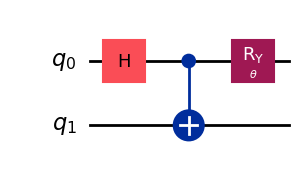

In [25]:
theta = Parameter("$\\theta$")

chsh_circuit_no_meas = QuantumCircuit(2)
chsh_circuit_no_meas.h(0)
chsh_circuit_no_meas.cx(0, 1)
chsh_circuit_no_meas.ry(theta, 0)
chsh_circuit_no_meas.draw(output="mpl", idle_wires=False, style="iqp")

### Create a list of phase values to be assigned later

After creating the parameterized CHSH circuit, you will create a list of phase values to be assigned to the circuit in the next step. You can use the following code to create a list of 21 phase values range from $0$ to $2 \pi$ with equal spacing, that is, $0$, $0.1 \pi$, $0.2 \pi$, ..., $1.9 \pi$, $2 \pi$.

In [26]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

### Observables 

Now we need observables from which to compute the expectation values.  In our case we are looking at orthogonal bases for each qubit, letting the parameterized $Y-$ rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis. We will therefore choose the observables $ZZ$, $ZX$, $XZ$, and $XX$.

In [27]:
ZZ = SparsePauliOp.from_list([("ZZ", 1)])
ZX = SparsePauliOp.from_list([("ZX", 1)])
XZ = SparsePauliOp.from_list([("XZ", 1)])
XX = SparsePauliOp.from_list([("XX", 1)])

ops = [ZZ, ZX, XZ, XX]
num_ops = len(ops)

## Optimize the circuits and operators

For this example, the circuit the operators are simple, so no optimizations are needed.

## Execute using a quantum primitive function

In order to execute the entire experiment in one call to the [`Estimator`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Estimator#estimator) we need to batch the circuit and operators together, repeating each for the requested `number_of_phases` points.

In [32]:
batch_circuits = [chsh_circuit_no_meas] * number_of_phases * num_ops
batch_ops = [op for op in ops for _ in individual_phases]

We can create a [Qiskit Runtime `Estimator`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Estimator#estimator) primitive to compute our expectation values, and the [`Batch`](https://docs.quantum-computing.ibm.com/run/run-primitives-batch) context manager to run our non-iterative workload.

In [36]:
# To run on local simulator:
#   1. Use the Estimator from qiskit.primitives instead
#   2. Remove the Batch context manager below

with Batch(backend=backend) as batch:
    estimator = Estimator()

    batch_expvals = (
        estimator.run(
            batch_circuits, batch_ops, parameter_values=individual_phases * num_ops, shots=10000
        )
        .result()
        .values
    )

The individual expectation values can then be extracted from the batched results:

In [37]:
ZZ_expval, ZX_expval, XZ_expval, XX_expval = [
    batch_expvals[kk * number_of_phases : (kk + 1) * number_of_phases] for kk in range(num_ops)
]

## Analyze the results

After running the circuits, we need to build the CHSH witness functions. We first build the quantities $\langle AB \rangle$, $\langle Ab \rangle$, $\langle aB \rangle$, and $\langle ab \rangle$, by looking at the parity of the outcomes for the four families of circuits we built (two measurement bases for each of the two qubits). Then we use those quantities to build the witness functions as defined previously.

In [38]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab>
chsh1_est = ZZ_expval - ZX_expval + XZ_expval + XX_expval

# <CHSH2> = <AB> + <Ab> - <aB> + <ab>
chsh2_est = ZZ_expval + ZX_expval - XZ_expval + XX_expval

Note that now we do not have to build the observables ourselves because they are returned to us! The computed expectation values are given in `result.values`. What comes back is a very small payload of data.

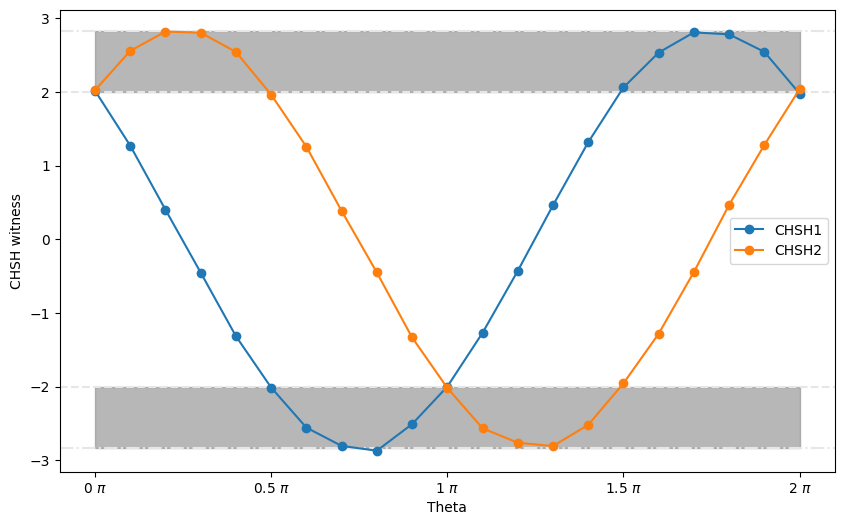

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

In the figure, the red dashed lines delimit the classical bounds ($\pm 2$) and the dash-dotted blue lines delimit the quantum bounds ($\pm 2\sqrt{2}$). You can see that the experimental results resemble the general trend of the simulated results and there are regions where the CHSH witness quantities exceeds the classical bounds. Congratulations! You have successfully demonstrated the violation of CHSH inequality in a real quantum system!

In [ ]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.14.1'

In [ ]:
import qiskit

qiskit.version.get_version_info()

'0.45.0'